In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Raising taxes on tobacco
## Dove siamo oggi
- [Tobacco MPOWER: Raise taxes on tobacco](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/raising-taxes-on-tobacco)

Nel tab Data è presente una tabella con punteggi (1–5) per ogni Paese e anno; il punteggio sintetizza la quota del prezzo al dettaglio costituita da tasse
- 1 = dati non riportati;
- 2 ≤ 25 %;
- 3 = 26–50 %;
- 4 = 51–75 %;
- 5 > 75 %.

La metadata descrive l’indicatore come score (id 374) ed elenca tutte le componenti fiscali considerate (accisa, IVA, dazi)


In [2]:
# Raising taxes on tobacco
df_taxes = pd.read_csv('data/R/raising_taxes.csv')
df_taxes

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,R_Group,Raising taxes on tobacco,numeric,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,EN,2023-10-17T22:00:00.000Z
1,R_Group,Raising taxes on tobacco,numeric,EMR,Eastern Mediterranean,Country,DJI,Djibouti,Year,2022,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,EN,2023-10-17T22:00:00.000Z
2,R_Group,Raising taxes on tobacco,numeric,AFR,Africa,Country,ERI,Eritrea,Year,2022,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,EN,2023-10-17T22:00:00.000Z
3,R_Group,Raising taxes on tobacco,numeric,AFR,Africa,Country,GIN,Guinea,Year,2022,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,EN,2023-10-17T22:00:00.000Z
4,R_Group,Raising taxes on tobacco,numeric,EUR,Europe,Country,MCO,Monaco,Year,2022,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,EN,2023-10-17T22:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750,R_Group,Raising taxes on tobacco,numeric,AMR,Americas,Country,VEN,Venezuela (Bolivarian Republic of),Year,2007,...,NaN,NaN,NaN,NaN,NaN,Not applicable,590.0,NaN,EN,2023-10-17T22:00:00.000Z
1751,R_Group,Raising taxes on tobacco,numeric,WPR,Western Pacific,Country,VNM,Viet Nam,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Not applicable,590.0,NaN,EN,2023-10-17T22:00:00.000Z
1752,R_Group,Raising taxes on tobacco,numeric,EMR,Eastern Mediterranean,Country,YEM,Yemen,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Not applicable,590.0,NaN,EN,2023-10-17T22:00:00.000Z
1753,R_Group,Raising taxes on tobacco,numeric,AFR,Africa,Country,ZMB,Zambia,Year,2007,...,NaN,NaN,NaN,NaN,NaN,Not applicable,590.0,NaN,EN,2023-10-17T22:00:00.000Z


In [3]:
import plotly.express as px

# Custom color mapping for each category
custom_colors = [
    "#e0e0e0",  # No data (gray)
    "#f9e79f",  # ≤25% (light yellow)
    "#f7b731",  # 26–50% (orange)
    "#e67e22",  # 51–75% (dark orange)
    "#229954"  # >75% (green)
]

value_labels = {
    "1": "No data",
    "2": "≤25%",
    "3": "26–50%",
    "4": "51–75%",
    "5": ">75%"
}
df_taxes['ValueLabel'] = df_taxes['Value'].map(value_labels)

fig = px.choropleth(
    df_taxes,
    locations="SpatialDimValueCode",
    color="ValueLabel",
    title="Raising taxes on tobacco (2022)",
    hover_name="Location",
    category_orders={"ValueLabel": ["No data", "≤25%", "26–50%", "51–75%", ">75%"]},
    labels={"ValueLabel": "Score category"},
    color_discrete_sequence=custom_colors
)
fig.update_layout(legend_title_text="Tax Score Category")
fig.show()

> - **Title**: Global map by tax-share category of the retail price of the most-sold brand (20 cigarettes).
> - Key messages:
>     - The >75% tier (green) covers a minority of countries, concentrated in Europe and the Western Pacific, with isolated cases in the Americas and Africa.
>     - Many countries fall in the 51–75% band (orange); a large share of the world remains ≤50% (yellow/ochre).
>     - Policy gap vs the WHO benchmark (≥75%): room to raise excise, indexation, and rebalance the tax mix.

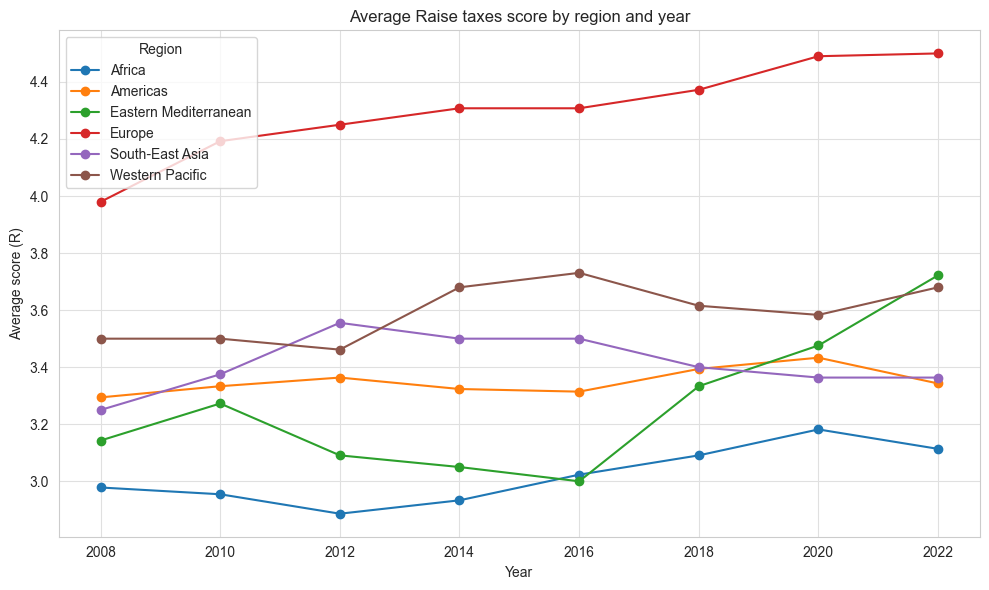

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df_taxes_all = pd.read_csv('data/R/raising_taxes.csv')

df_taxes_all['Value'] = pd.to_numeric(df_taxes_all['Value'], errors='coerce')
df_taxes_all['Period'] = pd.to_numeric(df_taxes_all['Period'], errors='coerce')
df_taxes_all['Value'] = df_taxes_all['Value'].where(df_taxes_all['Value'] != 1, pd.NA)

df_region_year = (
    df_taxes_all
    .dropna(subset=['ParentLocation', 'Period', 'Value'])
    .groupby(['ParentLocation', 'Period'], as_index=False)
    .agg(mean_value=('Value', 'mean'))
)

plt.figure(figsize=(10, 6))
plt.grid(True, zorder=0, color='#e0e0e0')
for region, group in df_region_year.groupby('ParentLocation'):
    plt.plot(group['Period'], group['mean_value'], marker='o', label=region, zorder=2)
plt.title('Average Raise taxes score by region and year')
plt.xlabel('Year')
plt.ylabel('Average score (R)')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

> - **Title**: Average score by Region over time
> - Key messages:
>     - Europe is the consistent leader, rising to about 4.5 in 2020–2022 (close to the >75% class).
>     - Western Pacific runs second at ~3.6–3.7: step-up in 2014–2016, slight dip in 2018–2020, uptick in 2022.
>     - South-East Asia remains stable around ~3.4–3.5, with a mild softening after 2018.
>     - Americas are flat near ~3.3–3.4.
>     - Eastern Mediterranean shows a strong catch-up after 2016 (from ~3.0 to ~3.7 by 2022).
>     - Africa stays the lowest, with gradual progress (from <3.0 to ~3.1–3.2; slight pullback in 2022).


## Quanto pesano le tasse sul prezzo
- [Tobacco: cigarette most sold brand, affordability](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/affordability-of-the-most-sold-brand-of-cigarettes-(tobacco-control--raise-taxes))
- [Tobacco retail price for a pack of 20 cigarettes: premium brand and cheapest brand](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-tobacco-control-raise-taxes-retail-price-for-a-pack-of-20-cigarettes)
- [Tobacco national taxes and retail price for a pack of 20 cigarettes (most sold brand)](https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-tobacco-control-raise-taxes-national-taxes-pack-of-20)

In [5]:
df_taxes = pd.read_csv('data/R/gho-tobacco-control-raise-taxes-national-taxes-pack-of-20.csv')
df_taxes

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,TOB_R_PRICE,Retail price for tobacco and nicotine products,text,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-01-10T23:00:00.000Z
1,TOB_R_PRICE,Retail price for tobacco and nicotine products,text,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-01-10T23:00:00.000Z
2,TOB_R_PRICE,Retail price for tobacco and nicotine products,text,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-01-10T23:00:00.000Z
3,TOB_R_PRICE,Retail price for tobacco and nicotine products,text,EMR,Eastern Mediterranean,Country,AFG,Afghanistan,Year,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EN,2024-01-10T23:00:00.000Z
4,TOB_R_PRICE,Retail price for tobacco and nicotine products,text,WPR,Western Pacific,Country,BRN,Brunei Darussalam,Year,2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No retail sale of cigarettes or renewal of cig...,EN,2024-01-10T23:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15595,R_Total_tax,Taxes as a % of price: total tax,text,EUR,Europe,Country,SVK,Slovakia,Year,2008,...,NaN,NaN,NaN,NaN,NaN,84.61,NaN,NaN,EN,2023-12-14T23:00:00.000Z
15596,R_Total_tax,Taxes as a % of price: total tax,text,EMR,Eastern Mediterranean,Country,TUN,Tunisia,Year,2008,...,NaN,NaN,NaN,NaN,NaN,85.03,NaN,NaN,EN,2023-12-14T23:00:00.000Z
15597,R_Total_tax,Taxes as a % of price: total tax,text,EUR,Europe,Country,BGR,Bulgaria,Year,2008,...,NaN,NaN,NaN,NaN,NaN,85.44,NaN,NaN,EN,2023-12-14T23:00:00.000Z
15598,R_Total_tax,Taxes as a % of price: total tax,text,AFR,Africa,Country,CPV,Cabo Verde,Year,2008,...,NaN,NaN,NaN,NaN,NaN,9.66,NaN,NaN,EN,2023-12-14T23:00:00.000Z


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Caricamento ---
df = pd.read_csv("data/R/gho-tobacco-control-raise-taxes-national-taxes-pack-of-20.csv")

# Consideriamo la marca più venduta (20 sticks)
df = df[df['Dim1'] == 'Most sold brand of cigarettes (20 sticks)'].copy()

# Flag indicatori
is_price = df['Indicator'].eq('Retail price for tobacco and nicotine products')
is_total_tax = df['Indicator'].eq('Taxes as a % of price: total tax')

# Totale tasse (% prezzo)
tax_total = (
    df[is_total_tax][['ParentLocation', 'Location', 'Period', 'FactValueNumeric']]
    .rename(columns={'FactValueNumeric': 'total_tax_pct'})
    .dropna(subset=['total_tax_pct'])
)

# Componenti delle tasse (% prezzo)
components_map = {
    'Taxes as a % of price: specific excise': 'specific_excise_pct',
    'Taxes as a % of price: ad valorem excise': 'ad_valorem_excise_pct',
    'Taxes as a % of price: value added tax': 'vat_pct',
    'Taxes as a % of price: import duties': 'import_duties_pct',
    'Taxes as a % of price: other taxes': 'other_taxes_pct',
}
comp_df = (
    df[df['Indicator'].isin(components_map.keys())]
    [['ParentLocation', 'Location', 'Period', 'Indicator', 'FactValueNumeric']]
    .dropna(subset=['FactValueNumeric'])
    .replace({'Indicator': components_map})
    .pivot_table(index=['ParentLocation', 'Location', 'Period'],
                 columns='Indicator', values='FactValueNumeric',
                 aggfunc='first')
    .reset_index()
)

# Prezzo in US$ (puoi cambiare in PPP o valuta locale modificando Dim2)
price_usd = (
    df[is_price & df['Dim2'].eq('In US$ at official exchange rates')]
    [['ParentLocation', 'Location', 'Period', 'FactValueNumeric']]
    .rename(columns={'FactValueNumeric': 'price_usd'})
    .dropna(subset=['price_usd'])
)

# Merge "wide"
wide = (
    tax_total.merge(comp_df, on=['ParentLocation', 'Location', 'Period'], how='outer')
    .merge(price_usd, on=['ParentLocation', 'Location', 'Period'], how='left')
)

# Derivati utili
wide['net_of_tax_pct'] = np.where(wide['total_tax_pct'].notna(),
                                  100 - wide['total_tax_pct'], np.nan)
wide['net_of_tax_amount_usd'] = np.where(
    wide['price_usd'].notna() & wide['total_tax_pct'].notna(),
    wide['price_usd'] * (100 - wide['total_tax_pct']) / 100.0, np.nan
)
wide['tax_amount_usd'] = np.where(
    wide['price_usd'].notna() & wide['total_tax_pct'].notna(),
    wide['price_usd'] * wide['total_tax_pct'] / 100.0, np.nan
)

# Calcolo e stampa della somma delle componenti per verifica
components = [
    'specific_excise_pct', 'ad_valorem_excise_pct', 'vat_pct',
    'import_duties_pct', 'other_taxes_pct'
]
regions = ['Americas', 'Europe']

for region in regions:
    grouped = (
        wide[wide['ParentLocation'] == region]
        .groupby(['ParentLocation', 'Period'])[components]
        .mean()
        .sort_index()
    )
    if grouped.empty:
        continue

    grouped['sum_components'] = grouped.sum(axis=1)

In [7]:
# --- Parametri modificabili ---
country = "Italy"
year = 2022

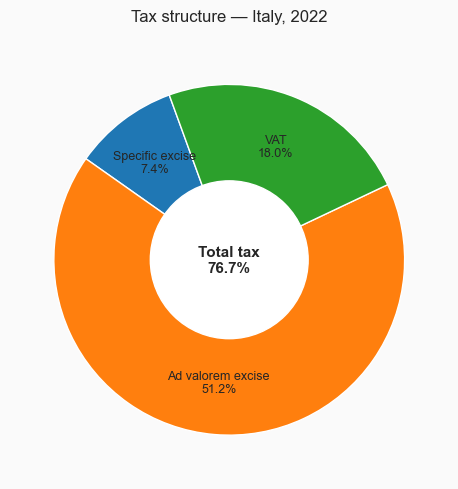

In [8]:
import matplotlib.pyplot as plt
import numpy as np

component_cols = [
    'specific_excise_pct', 'ad_valorem_excise_pct', 'vat_pct',
    'import_duties_pct', 'other_taxes_pct'
]
nice_labels = {
    'specific_excise_pct': 'Specific excise',
    'ad_valorem_excise_pct': 'Ad valorem excise',
    'vat_pct': 'VAT',
    'import_duties_pct': 'Import duties',
    'other_taxes_pct': 'Other taxes'
}
component_colors = {
    'Specific excise': '#1f77b4',
    'Ad valorem excise': '#ff7f0e',
    'VAT': '#2ca02c',
    'Import duties': '#d62728',
    'Other taxes': '#9467bd'
}

row = wide[(wide['Location'] == country) & (wide['Period'] == year)]

if row.empty:
    print(f"No data for {country} in {year}.")
else:
    data = (
        row[component_cols]
        .iloc[0]
        .rename(index=nice_labels)
        .dropna()
        .astype(float)
    )
    data = data[data > 0]
    if data.empty:
        print(f"No non-zero tax components for {country} in {year}.")
    else:
        fig, ax = plt.subplots(figsize=(5, 5), facecolor="#fafafa")
        colors = [component_colors[label] for label in data.index]
        wedges, _ = ax.pie(
            data.values,
            labels=None,
            startangle=110,
            colors=colors,
            wedgeprops=dict(linewidth=1, edgecolor="white"),
            radius=1
        )
        for w, label, val in zip(wedges, data.index, data.values):
            ang = (w.theta2 + w.theta1) / 2.0
            rad = 0.7
            x = rad * np.cos(np.deg2rad(ang))
            y = rad * np.sin(np.deg2rad(ang))
            ax.text(
                x, y,
                f"{label}\n{val:.1f}%",
                ha="center", va="center",
                fontsize=9,
                linespacing=1.1
            )
        centre_circle = plt.Circle((0, 0), 0.45, fc="white")
        ax.add_artist(centre_circle)
        total_tax = row['total_tax_pct'].iloc[0] if 'total_tax_pct' in row and pd.notna(
            row['total_tax_pct'].iloc[0]) else np.nan
        center_text = f"Total tax\n{total_tax:.1f}%" if not np.isnan(total_tax) else "n/a"
        ax.text(0, 0, center_text, ha="center", va="center", fontsize=11, fontweight="bold")
        ax.set_title(f"Tax structure — {country}, {year}", pad=14, fontsize=12)
        plt.tight_layout()
        plt.show()

> - **Title**: Tax structure — Italy, 2022
> - Key messages:
>     - Italy meets the benchmark with 76.7% total taxes.
>     - Composition: Ad valorem 51.2%, VAT 18.0%, Specific excise 7.4%; import/other ≈ 0%.
>     - Reading: a structure dominated by ad valorem is more sensitive to list prices; low specific excise weakens the minimum price “floor”.
>     - Implications: consider raising the specific share and ensuring regular indexation to sustain health impact.

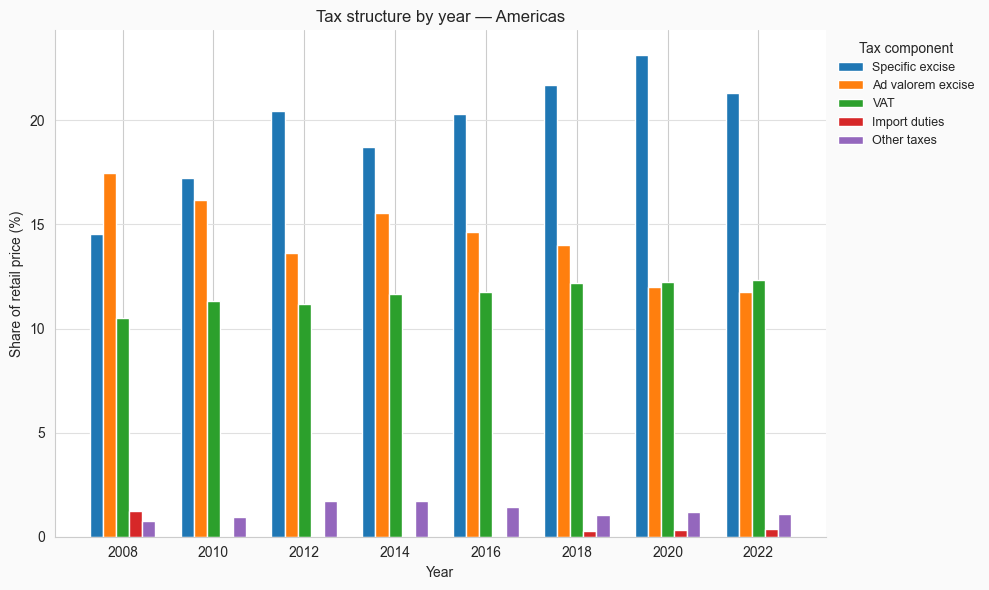

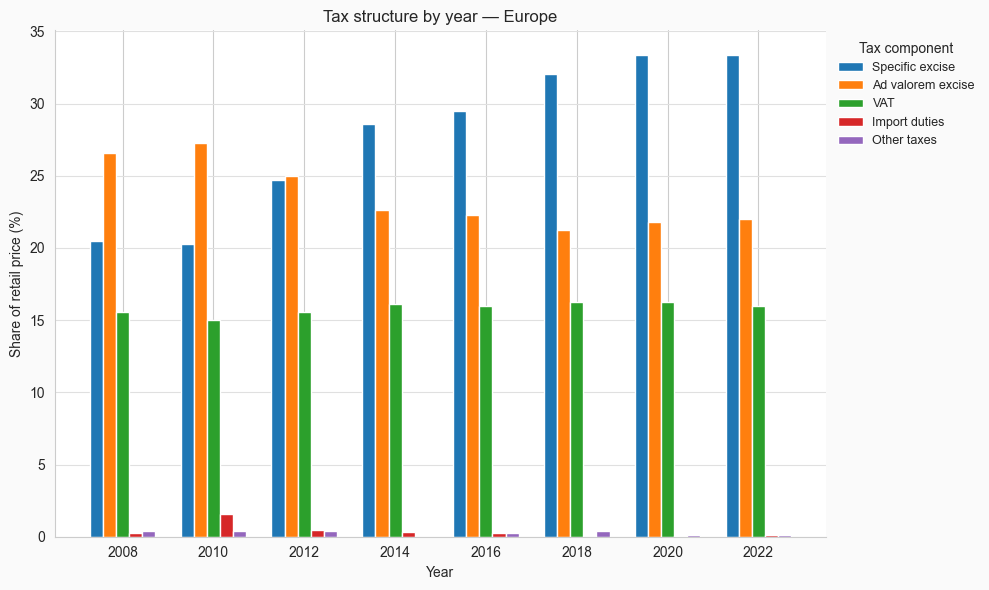

In [9]:
import numpy as np
import matplotlib.pyplot as plt

regions = ['Americas', 'Europe']
components = [
    'specific_excise_pct', 'ad_valorem_excise_pct', 'vat_pct',
    'import_duties_pct', 'other_taxes_pct'
]
labels = ['Specific excise', 'Ad valorem excise', 'VAT', 'Import duties', 'Other taxes']
colors = plt.get_cmap('tab10').colors[:5]

bar_width = 0.13
group_gap = 0.25  # space between groups

for region in regions:
    grouped = (
        wide[wide['ParentLocation'] == region]
        .groupby(['ParentLocation', 'Period'])[components]
        .mean()
        .sort_index()
    )
    if grouped.empty:
        continue

    plot_data = grouped[components]
    n_years = len(plot_data)
    n_comps = len(components)
    indices = np.arange(n_years) * (n_comps * bar_width + group_gap)

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#fafafa')
    ax.grid(True, zorder=0, color='#e0e0e0', linewidth=0.8, axis='y')
    for i, (comp, color, label) in enumerate(zip(components, colors, labels)):
        ax.bar(indices + i * bar_width, plot_data[comp], width=bar_width, label=label, color=color, zorder=2)

    years = [str(idx[1]) for idx in plot_data.index]
    ax.set_xticks(indices + (n_comps / 2 - 0.5) * bar_width)
    ax.set_xticklabels(years)
    ax.set_xlabel('Year')
    ax.set_ylabel('Share of retail price (%)')
    ax.set_title(f'Tax structure by year — {region}')
    ax.legend(title='Tax component', loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

> - **Title**: Tax structure over time — Americas/Europe
> - Americas
>     - Shift toward specific excise: ~15% (2008) → ~22–23% (peak 2018–2020), slight dip in 2022.
>     - Ad valorem declining: ~17–18% → ~12% by 2020–2022.
>     - VAT inching up: ~10–11% → ~12% in 2022.
>     - Import/other taxes: negligible (≈0–1%).
>     - **A more specific/mixed profile, yet many countries remain below ≥75%—room to raise specific and index.**
>
> - Europe
>     - Strong shift to specific excise: ~20% (2008) → ~33% (2020–2022).
>     - Ad valorem down: ~26–27% → ~21–22%.
>     - VAT stable: ~15–16%.
>     - Import/other: near zero.
>     - **A specific-heavy mix stabilizes prices and supports achieving the ≥75% benchmark.**

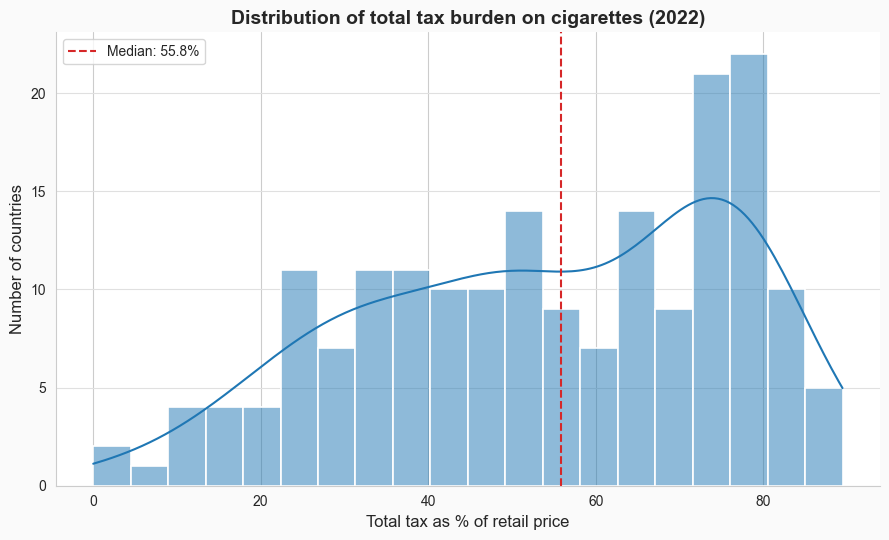

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

tax_year = wide[wide['Period'] == year].dropna(subset=['total_tax_pct'])
color = "#1f77b4"

plt.figure(figsize=(9, 5.5), facecolor="#fafafa")
sns.histplot(
    tax_year['total_tax_pct'],
    bins=20,
    color=color,
    edgecolor='white',
    kde=True,
    linewidth=1.2,
    zorder=2
)
median = tax_year['total_tax_pct'].median()
plt.axvline(median, color='#d62728', linestyle='--', linewidth=1.5, label=f"Median: {median:.1f}%")
#plt.text(median + 1, plt.ylim()[1] * 0.92, f"{median:.1f}%", color='#d62728', fontsize=11, va='top', fontweight='bold')

plt.xlabel("Total tax as % of retail price", fontsize=12)
plt.ylabel("Number of countries", fontsize=12)
plt.title(f"Distribution of total tax burden on cigarettes ({year})", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', color='#e0e0e0', linewidth=0.8, zorder=0)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

> - **Title**: Distribution of total tax burden on cigarettes (2022)
> - Key messages
>     - Global median: 55.8% → below the WHO benchmark ≥75%.
>     - Wide dispersion: many countries at 25–60%, with a noticeable mass around 65–85%.
>     - Left tail: a few countries <25%, indicating substantial headroom to raise taxes.
>     - **Countries at ≥75% remain a minority; scope to increase excise and index regularly.**


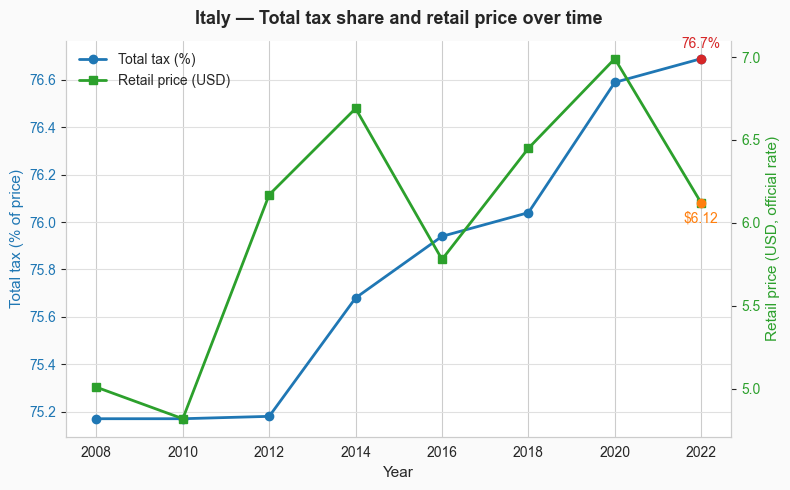

In [11]:
import matplotlib.pyplot as plt

series = wide[wide['Location'] == country].sort_values('Period')
if not series.empty:
    fig, ax1 = plt.subplots(figsize=(8, 5), facecolor="#fafafa")
    ax1.plot(series['Period'], series['total_tax_pct'], marker='o', color='#1f77b4', label='Total tax (%)', linewidth=2)
    ax1.set_ylabel("Total tax (% of price)", color='#1f77b4', fontsize=11)
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.set_xlabel("Year", fontsize=11)
    ax1.set_title(f"{country} — Total tax share and retail price over time", fontsize=13, fontweight='bold', pad=12)

    # Add grid to ax1
    ax1.grid(axis='y', color='#e0e0e0', linewidth=0.8, zorder=0)

    # Highlight last point
    if not series['total_tax_pct'].isna().all():
        ax1.scatter(series['Period'].iloc[-1], series['total_tax_pct'].iloc[-1], color='#d62728', zorder=5)
        ax1.annotate(f"{series['total_tax_pct'].iloc[-1]:.1f}%",
                     (series['Period'].iloc[-1], series['total_tax_pct'].iloc[-1]),
                     textcoords="offset points", xytext=(0, 8), ha='center', color='#d62728', fontsize=10)

    ax2 = ax1.twinx()
    ax2.plot(series['Period'], series['price_usd'], marker='s', color='#2ca02c', label='Retail price (USD)',
             linewidth=2)
    ax2.set_ylabel("Retail price (USD, official rate)", color='#2ca02c', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='#2ca02c')

    # Add grid to ax2 (optional, for right y-axis)
    ax2.grid(False)  # Keep only one grid for clarity

    # Highlight last point
    if not series['price_usd'].isna().all():
        ax2.scatter(series['Period'].iloc[-1], series['price_usd'].iloc[-1], color='#ff7f0e', zorder=5)
        ax2.annotate(f"${series['price_usd'].iloc[-1]:.2f}",
                     (series['Period'].iloc[-1], series['price_usd'].iloc[-1]),
                     textcoords="offset points", xytext=(0, -14), ha='center', color='#ff7f0e', fontsize=10)

    # Legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False, fontsize=10)

    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()

> - **Title**: Italy — Total tax share and retail price over time
> - Key messages:
>     - Italy is consistently ≥75% throughout; 2022: 76.7% (red dot).
>     - Tax share trend: modest rise ~75.2% → 76.7% (+1.5 pp), stable after 2016.
>     - Price (USD): increases to 2020 (~\\$7.0), then falls in 2022 (\\$6.12).
>     - 2016 divergence: tax share up while USD price dips → likely exchange-rate effects plus tax-mix changes.
>     - **Benchmark met; keep indexing the specific excise and track FX effects on USD price.**

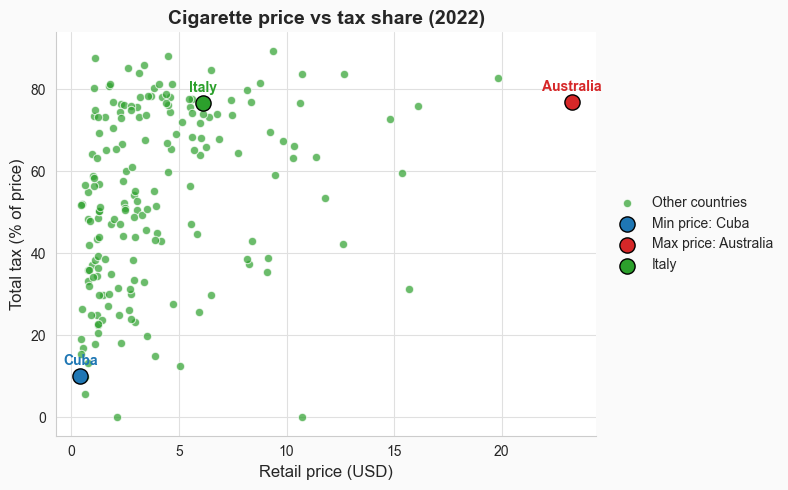

In [12]:
import matplotlib.pyplot as plt
from collections import OrderedDict

# Use USD prices and drop missing values
scatter = wide[(wide['Period'] == year) & wide['price_usd'].notna() & wide['total_tax_pct'].notna()]

base_color = "#2ca02c"
min_color = "#1f77b4"
max_color = "#d62728"

plt.figure(figsize=(8, 5), facecolor="#fafafa")
plt.scatter(
    scatter['price_usd'], scatter['total_tax_pct'],
    color=base_color, alpha=0.7, edgecolor='white', linewidth=0.8, label="Other countries"
)

# Find indices
min_idx = scatter['price_usd'].idxmin()
max_idx = scatter['price_usd'].idxmax()
italy_row = scatter[scatter['Location'] == "Italy"]

# Highlight min
row_min = scatter.loc[min_idx]
plt.scatter(
    row_min['price_usd'], row_min['total_tax_pct'],
    color=min_color, edgecolor='black', s=120, zorder=5, label=f"Min price: {row_min['Location']}"
)
plt.annotate(
    row_min['Location'],
    (row_min['price_usd'], row_min['total_tax_pct']),
    textcoords="offset points", xytext=(0, 8), ha='center',
    fontsize=10, color=min_color, fontweight='bold'
)

# Highlight max
row_max = scatter.loc[max_idx]
plt.scatter(
    row_max['price_usd'], row_max['total_tax_pct'],
    color=max_color, edgecolor='black', s=120, zorder=5, label=f"Max price: {row_max['Location']}"
)
plt.annotate(
    row_max['Location'],
    (row_max['price_usd'], row_max['total_tax_pct']),
    textcoords="offset points", xytext=(0, 8), ha='center',
    fontsize=10, color=max_color, fontweight='bold'
)

# Highlight Italy (same as base color, optional in legend)
if not italy_row.empty:
    row_italy = italy_row.iloc[0]
    plt.scatter(
        row_italy['price_usd'], row_italy['total_tax_pct'],
        color=base_color, edgecolor='black', s=120, zorder=5, label="Italy"
    )
    plt.annotate(
        "Italy",
        (row_italy['price_usd'], row_italy['total_tax_pct']),
        textcoords="offset points", xytext=(0, 8), ha='center',
        fontsize=10, color=base_color, fontweight='bold'
    )

plt.xlabel("Retail price (USD)", fontsize=12)
plt.ylabel("Total tax (% of price)", fontsize=12)
plt.title(f"Cigarette price vs tax share ({year})", fontsize=14, fontweight='bold')
plt.grid(axis='both', color='#e0e0e0', linewidth=0.8, zorder=0)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(),
    frameon=False,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
plt.tight_layout()
plt.show()

> - **Title**: Cigarette price vs tax share (2022)
> - Key messages:
>     - Overall positive association: higher prices generally pair with higher tax shares, but variance is large.
>     - High outlier: Australia — highest price with tax share >75%.
>     - Low outlier: Cuba — lowest price with very low tax share.
>     - Italy: about $6.1 and ~76.7% taxes — above the WHO benchmark (≥75%).
>     - **Differences reflect excise mix (specific vs ad valorem), pre-tax price levels, income, and exchange-rate effects.**

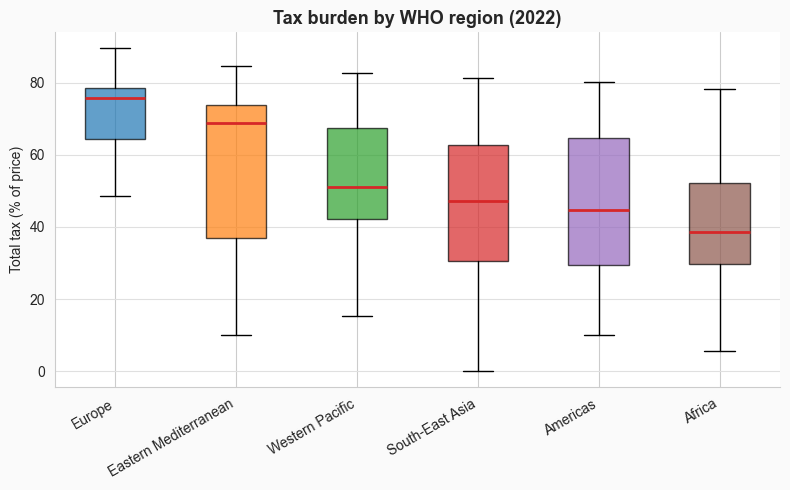

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
box = wide[wide['Period'] == year].dropna(subset=['total_tax_pct'])
ordered_regions = (box.groupby('ParentLocation')['total_tax_pct']
                   .median().sort_values(ascending=False).index.tolist())
data_by_region = [box[box['ParentLocation'] == r]['total_tax_pct'].values for r in ordered_regions]

# Custom colors for boxes
cmap = plt.get_cmap('tab10')
box_colors = [cmap(i % 10) for i in range(len(ordered_regions))]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="#fafafa")
bp = ax.boxplot(
    data_by_region,
    tick_labels=ordered_regions,
    vert=True,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color='#d62728', linewidth=2)
)

# Color each box
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add grid and style
ax.grid(axis='y', color='#e0e0e0', linewidth=0.8, zorder=0)
ax.set_ylabel("Total tax (% of price)")
ax.set_title(f"Tax burden by WHO region ({year})", fontsize=13, fontweight='bold')
plt.xticks(rotation=30, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

> - **Title**: Total tax burden by WHO Region (2022)
> - Key messages:
>     - Medians (≈): Europe ~77% (highest, near/above ≥75%); Eastern Mediterranean ~68%; Western Pacific ~50%; South-East Asia ~46%; Americas ~44%; Africa ~38%.
>     - Spread: Eastern Mediterranean and South-East Asia show the widest dispersion; Europe is concentrated at higher levels.
>     - WHO benchmark (≥75%): achieved on average only in Europe; elsewhere it’s confined to upper-quartile countries.
>     - **Policy signal: substantial room to raise taxes where medians are <50% (Africa, Americas, SE Asia).**